In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Overview of the Data

I query the database in order to get a list of all tables and views that are in the database

In [2]:
%%sql
SELECT
    name,
    type
  FROM sqlite_master
 WHERE type IN ("table", "view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


*Write one or two queries to get familiar with the tables*

In [3]:
%%sql
SELECT *
  FROM invoice
 LIMIT 5;


 * sqlite:///chinook.db
Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83


In [4]:
%%sql
SELECT *
  FROM invoice_line
 LIMIT 5

 * sqlite:///chinook.db
Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity
1,1,1158,0.99,1
2,1,1159,0.99,1
3,1,1160,0.99,1
4,1,1161,0.99,1
5,1,1162,0.99,1


In [5]:
%%sql
SELECT *
  FROM genre
 LIMIT 5

 * sqlite:///chinook.db
Done.


genre_id,name
1,Rock
2,Jazz
3,Metal
4,Alternative & Punk
5,Rock And Roll


In [6]:
%%sql
SELECT *
  FROM track
 LIMIT 5

 * sqlite:///chinook.db
Done.


track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99
4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman",252051,4331779,0.99
5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


# Selecting Albums to Purchase

I'll write a query to find out which genres sell the most tracks in the USA, write up a summary of the findings, and make a recommendation for the three artists whose albums should be purchased for the store.

The query returns each genre, with the number of tracks sold in the USA


In [7]:
query = """
WITH usa_tracks_country AS
    ( 
        SELECT 
            il.*
          FROM invoice_line il
         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
         INNER JOIN customer c ON c.customer_id = i.customer_id
         WHERE c.country = "USA"
    )
    
SELECT 
    g.name AS genre_name,
    COUNT(utc.track_id) AS number_of_tracks,
    ROUND(CAST(COUNT(utc.track_id) AS FLOAT)/ (SELECT COUNT(*) FROM usa_tracks_country) * 100, 2) AS percentage
  FROM track t
 INNER JOIN genre g ON t.genre_id = g.genre_id
 INNER JOIN usa_tracks_country utc ON t.track_id = utc.track_id
 GROUP BY 1
 ORDER BY 2 DESC
"""

# Reading SQL results into a pandas DataFrame
connect = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, connect)
df

,genre_name,number_of_tracks,percentage
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Pop,22,2.09
7,Latin,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


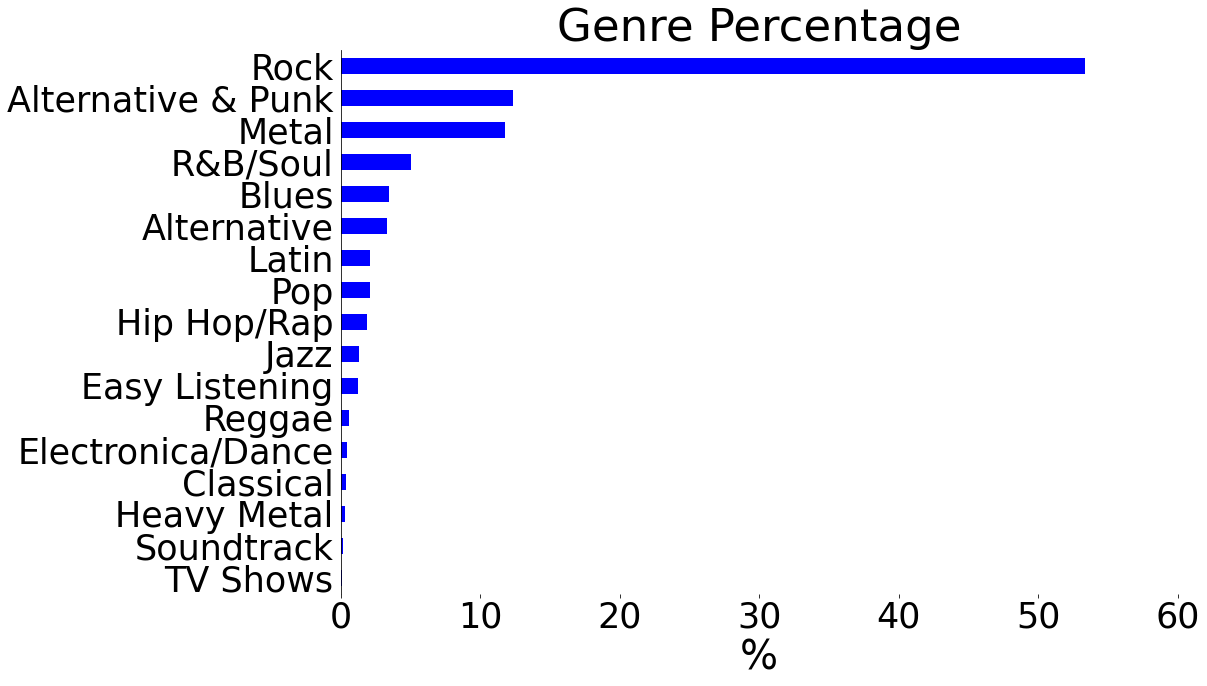

In [8]:
# Plotting a chart for the table above

# reseting the index
df = df.set_index("genre_name", drop= True)

# plotting

fig, ax = plt.subplots(figsize=(15,10))
df["percentage"].sort_values().plot.barh(color= "blue",
                            xlim= (0,60),
                          rot= 0)
ax.set_title("Sold Tracks by Genre", size= 45)
ax.set_ylabel(None)
ax.set_xlabel("%", fontsize=40)
ax.tick_params(axis="both", 
               labelsize=35, 
               left = False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)




We can see that Rock, Alternative & Punk and Metal are the most sold genres in Chinook. Therefore, the recommendation here is to purchase albums that go with these genres

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.

In [10]:
%%sql

SELECT
    e.*
  FROM employee e

 * sqlite:///chinook.db
Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
6,Mitchell,Michael,IT Manager,1,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
7,King,Robert,IT Staff,6,1970-05-29 00:00:00,2017-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
8,Callahan,Laura,IT Staff,6,1968-01-09 00:00:00,2017-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


In [11]:

query ="""
SELECT 
    e1.employee_id,
    e1.first_name || " " || e1.last_name AS employee_name,
    e2.first_name || " " || e2.last_name AS supervisor_name,
    ROUND(SUM(i.total),1) AS total_sales_amount
 FROM employee e1
 INNER JOIN customer c ON c.support_rep_id = e1.employee_id
 INNER JOIN invoice i ON i.customer_id = c.customer_id
 INNER JOIN employee e2 ON e1.reports_to = e2.employee_id
 GROUP BY 1,2
 ORDER BY 3 DESC
 """


It looks that Jane Peacock is the employee that brings in the most sales. All the employees report to Nancy Edwards.

## Analyzing Sales by Country

Write a query that collates data on purchases from different countries.
- Where a country has only one customer, collect them into an "Other" group.
- The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
- For each country, include:
    - total number of customers
    - total value of sales
    - average value of sales per customer
    - average order value

In [12]:
%%sql

WITH country_or_other AS (
        SELECT
        CASE
            WHEN (SELECT COUNT(*)
                  FROM customer
                  WHERE country = c.country) = 1 THEN "Other"
            ELSE country
            END AS country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer C ON c.customer_id = i.customer_id
                        )

SELECT
    country,
    number_of_customers,
    total_sales,
    customer_lifetime_value,
    average_order_value
FROM (
    SELECT
        country,
        COUNT(DISTINCT customer_id) AS number_of_customers,
        SUM(unit_price) AS total_sales,
        SUM(unit_price) / COUNT( DISTINCT customer_id) AS customer_lifetime_value,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) AS average_order_value,
        CASE 
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY 1
    ORDER BY sort ASC, 3 DESC -- # sort is used as a sorting column that is invisible (not present in the SELECT query)-- 
                              -- # to force "Other" at the bottom--
)


 * sqlite:///chinook.db
Done.


country,number_of_customers,total_sales,customer_lifetime_value,average_order_value
USA,13,1040.490000000008,80.03769230769292,7.942671755725252
Canada,8,535.5900000000034,66.94875000000043,7.047236842105309
Brazil,5,427.68000000000245,85.53600000000048,7.011147540983647
France,5,389.0700000000021,77.81400000000042,7.781400000000042
Germany,4,334.6200000000016,83.6550000000004,8.161463414634186
Czech Republic,2,273.24000000000103,136.62000000000052,9.108000000000034
United Kingdom,3,245.52000000000078,81.84000000000026,8.768571428571457
Portugal,2,185.13000000000022,92.56500000000011,6.3837931034482835
India,2,183.1500000000002,91.5750000000001,8.72142857142858
Other,15,1094.9400000000085,72.99600000000056,7.448571428571486


# Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album.
- We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. 
- We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. 
It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

Up until now, we've only ever compared two single values, using operators like `=` `!=` and `LIKE`. To compare two tables of value, we can use the `EXCEPT` operator that we learned in the previous lesson.

Once we've made the comparison, we can wrap it in a `CASE` statement to add a column that tells us if that invoice was an album purchase or not.

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
- Number of invoices
- Percentage of invoices

In [13]:
%%sql

SELECT
    il.invoice_id,
    t.album_id,
    t.track_id
  FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id

 * sqlite:///chinook.db
Done.


invoice_id,album_id,track_id
1,91,1158
1,91,1159
1,91,1160
1,91,1161
1,91,1162
1,91,1163
1,91,1164
1,91,1165
1,91,1166
1,91,1167


In [14]:
%%sql

SELECT
    il.invoice_id,
    COUNT(t.track_id),
    COUNT(DISTINCT t.album_id),
    album_id
  FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
GROUP BY 1

 * sqlite:///chinook.db
Done.


invoice_id,COUNT(t.track_id),COUNT(DISTINCT t.album_id),album_id
1,16,1,91
2,10,10,322
3,2,2,203
4,8,8,314
5,17,1,163
6,2,2,83
7,11,11,322
8,10,10,183
9,9,9,21
10,2,2,215


In [15]:
%%sql
WITH invoice_first_track AS (
    SELECT
    il.invoice_id invoice_id,
    MIN(il.track_id)
FROM invoice_line il
GROUP BY 1
)

SELECT 
    COUNT(DISTINCT invoice_id) AS number_of_invoices
FROM invoice_first_track    

 * sqlite:///chinook.db
Done.


number_of_invoices
614


In [16]:
%%sql
SELECT COUNT(*)
FROM invoice

 * sqlite:///chinook.db
Done.


COUNT(*)
614


In [17]:
%%sql

SELECT
        t.album_id album_id,
        COUNT(t.track_id) album_track_count
        FROM track t
        GROUP BY 1

 * sqlite:///chinook.db
Done.


album_id,album_track_count
1,10
2,1
3,3
4,8
5,15
6,13
7,12
8,14
9,8
10,14


In [18]:
%%sql

WITH invoice_album AS 
        (
        SELECT
            il.invoice_id,
            COUNT(t.track_id) track_count,
            COUNT(DISTINCT t.album_id) AS album_count,
            album_id
          FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        GROUP BY 1
        ),
    
    album_track_count AS 
        (
        SELECT
        t.album_id album_id,
        COUNT(t.track_id) album_track_count
        FROM track t
        GROUP BY 1
        )
        
SELECT 
    CASE
        WHEN ia.album_count = 1
        AND ia.track_count = atc.album_track_count --# because we are interested in purchases of the whole album not just a part of it--
        THEN "Album"
        ELSE "Single"
    END AS purchase_type,
    COUNT(ia.invoice_id) number_of_invoices,
    ROUND(CAST(COUNT(ia.invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice_album) * 100, 2) || " %" AS percentage
FROM invoice_album ia
INNER JOIN album_track_count atc ON atc.album_id = ia.album_id
GROUP BY 1

 * sqlite:///chinook.db
Done.


purchase_type,number_of_invoices,percentage
Album,114,18.57 %
Single,500,81.43 %


Steps for solving the problem using the `EXCEPT` operator

1. Get all the albums that were purchased in first place, to exclude the albums with zero sale:
2. Get all the purchased albums with the corresponding tracks combined in a single view:
3. On the other side, Get all the invoice line items combined with the corresponding tracks and albums:
4. Stitch the invoice ID with all the albums_tracks_purchased, irrespective if it was purchased within the same invoice or not, this query is used as a subquery in the last query:
5. Consolidate all the queries to get the final answer to our question, apparently 80% of our customers have purchased single tracks, so what chnook is considering is feasible and would save cost!

In this guided project we put our SQL joining skills to the test, using subqueries, multiple joins, set operations, aggregate functions and more.

If you'd like more practice, you can look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get you started:

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?